In [ ]:
!pip install realesrgan
from google.colab import drive
drive.mount('/content/drive')

import os
import sys
import glob
import time
import random

import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Libraries imported successfully.")
print(f"Using device: {device}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.4/299.4 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 25.3 MB/s eta 0:00:00
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214818 sha256=d7b0ed1945e83a0c1fcf48c6a56ec2a21dddb9ff699a2558480eba5eca609a64
  Stored in directory: /root/.cache/pip/wheels/9a/e3/e4/58f29bfabb622dd40b6d9839318ce5bf092062b81ca3aa19ea
  Created wheel for 

In [ ]:

!git clone https://github.com/TencentARC/GFPGAN.git
%cd GFPGAN

!pip install basicsr
!pip install facexlib
!pip install -r requirements.txt
!python setup.py develop

!wget https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.3.pth -P experiments/pretrained_models

print("Installation complete and Model Weights downloaded.")

Cloning into 'GFPGAN'...
remote: Enumerating objects: 527, done.
remote: Counting objects: 100% (272/272), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 527 (delta 221), reused 204 (delta 204), pack-reused 255 (from 1)
Receiving objects: 100% (527/527), 5.37 MiB | 13.10 MiB/s, done.
Resolving deltas: 100% (282/282), done.
/content/GFPGAN
/usr/local/lib/python3.12/dist-packages/setuptools/__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
running develop
/usr/local/lib/python3.12/dist-packages/setuptools/command/develop.py:41: EasyInstallDeprecationWarning: eas

In [ ]:
import os
import shutil
from google.colab import files
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

upload_folder = 'inputs/upload'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
os.makedirs(upload_folder, exist_ok=True)

print(f"Directory '{upload_folder}' created/ready.\n")

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

print("How would you like to provide the image?")
print("1: Upload from Computer")
print("2: Take Photo with Camera")
choice = input("Enter 1 or 2: ")

if choice == '1':
    print("\nPlease upload the photos you want to restore (JPG, PNG):")
    uploaded = files.upload()
    for filename in uploaded.keys():
        dst_path = os.path.join(upload_folder, filename)
        shutil.move(filename, dst_path)
        print(f"Successfully saved: {dst_path}")

elif choice == '2':
    try:
        print("\nStarting Camera... (Click 'Capture' when ready)")
        filename = take_photo('camera_capture.jpg')

        dst_path = os.path.join(upload_folder, filename)
        shutil.move(filename, dst_path)
        print(f"Successfully saved: {dst_path}")
    except Exception as e:
        print(f"Camera Error: {str(e)}")
        print("Please ensure your browser has permission to access the camera.")

else:
    print("Invalid choice. Please run the cell again.")

Directory 'inputs/upload' created/ready.

How would you like to provide the image?
1: Upload from Computer
2: Take Photo with Camera
Enter 1 or 2: 1

Please upload the photos you want to restore (JPG, PNG):


Saving unblur-sharpener-hero-before.webp to unblur-sharpener-hero-before.webp
Successfully saved: inputs/upload/unblur-sharpener-hero-before.webp


In [ ]:
import os
import sys

# !pip install realesrgan

def patch_basicsr():
    site_packages = [p for p in sys.path if 'site-packages' in p or 'dist-packages' in p]
    target_file = None
    for p in site_packages:
        possible_path = os.path.join(p, 'basicsr', 'data', 'degradations.py')
        if os.path.exists(possible_path):
            target_file = possible_path
            break

    if target_file:
        with open(target_file, 'r') as f: content = f.read()
        bad_import = 'from torchvision.transforms.functional_tensor import rgb_to_grayscale'
        good_import = 'from torchvision.transforms.functional import rgb_to_grayscale'
        if bad_import in content:
            content = content.replace(bad_import, good_import)
            with open(target_file, 'w') as f: f.write(content)
            print("PATCH APPLIED: Library fixed.")
        else:
            print("PATCH STATUS: File already fixed.")

patch_basicsr()

print("\nStarting Restoration...")
!python inference_gfpgan.py -i inputs/upload -o results -v 1.3 -s 2

output_folder = 'results/restored_imgs'
if os.path.exists(output_folder) and len(os.listdir(output_folder)) > 0:
    print("\nSUCCESS: Images processed.")
    print("Files found:", os.listdir(output_folder))
else:
    print("\nWARNING: No results found. Please check if 'inputs/upload' has images.")

PATCH APPLIED: Library fixed.

Starting Restoration...
Downloading: "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.1/RealESRGAN_x2plus.pth" to /usr/local/lib/python3.12/dist-packages/weights/RealESRGAN_x2plus.pth

100% 64.0M/64.0M [00:00<00:00, 331MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://github.com/xinntao/facexlib/releases/download/v0.1.0/detection_Resnet50_Final.pth" to /content/GFPGAN/gfpgan/weights/detection_Resnet50_Final.pth

100% 104M/104M [00:00<00:00, 382MB/s] 
Downloading: 

Found 1 images to display...


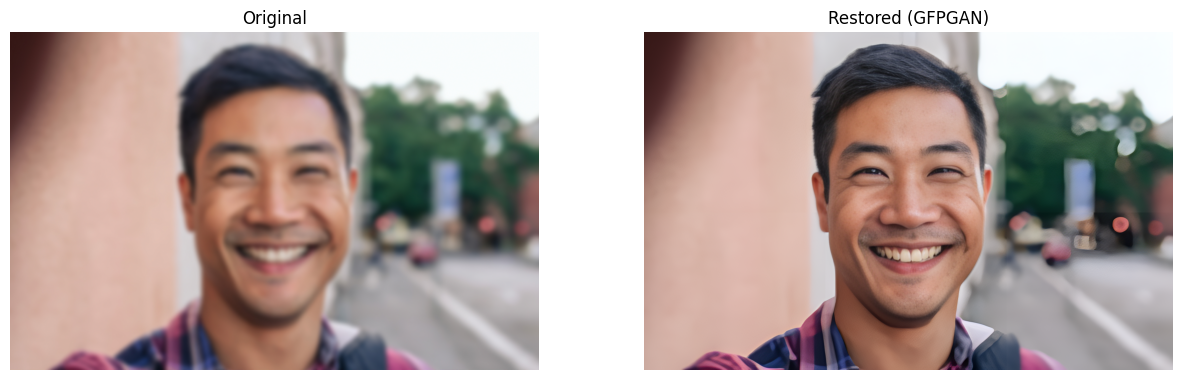

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

input_folder = '/content/GFPGAN/inputs/upload'
output_folder = '/content/GFPGAN/results/restored_imgs'

def display_before_after(image_name):
    input_path = os.path.join(input_folder, image_name)
    result_path = os.path.join(output_folder, image_name)

    if os.path.exists(result_path):
        img_input = cv2.imread(input_path)
        img_result = cv2.imread(result_path)

        if img_input is not None:
            img_input = cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB)
        if img_result is not None:
            img_result = cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(15, 10))

        plt.subplot(1, 2, 1)
        plt.title('Original')
        if img_input is not None:
            plt.imshow(img_input)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title('Restored (GFPGAN)')
        if img_result is not None:
            plt.imshow(img_result)
        plt.axis('off')

        plt.show()
    else:
        print(f"Result not found for {image_name}")

if os.path.exists(input_folder):
    files = os.listdir(input_folder)
    print(f"Found {len(files)} images to display...")
    for filename in files:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
            display_before_after(filename)
else:
    print(f"Error: Input folder not found at {input_folder}")

In [ ]:
import os
from google.colab import files

# 1. Define the folder containing the GFPGAN results
# We use the absolute path to be safe
results_folder = '/content/GFPGAN/results/restored_imgs'
zip_filename = 'restored_faces.zip'

# 2. Check if files exist and Zip them
if os.path.exists(results_folder) and len(os.listdir(results_folder)) > 0:
    print(f"Found files in {results_folder}. Zipping them now...")

    # Zip the folder (-r for recursive, -j to junk paths/flatten directory structure if you prefer,
    # but we will use -r to be safe)
    !zip -r -q {zip_filename} {results_folder}

    print(f"Zip created: {zip_filename}")
    print("Triggering download...")

    # 3. Download the zip file
    files.download(zip_filename)
else:
    print(f"ERROR: No files found in {results_folder}.")
    print("Please make sure the inference step (Step 4) ran successfully.")

Found files in /content/GFPGAN/results/restored_imgs. Zipping them now...
Zip created: restored_faces.zip
Triggering download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>